### Load Packages

In [1]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
#%matplotlib notebook
from IPython import display
import pandas as pd

import sys, subprocess
from PIL import Image
import pickle
from armcodlib import *
import keras.backend as K
import os
import cv2
from glob import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation


Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.0.0-alpha0


### Create arm positions dataset

Fixing parameters 

Creation of the training data: 
- train_posture_before : joint angles before command
- train_posture_after  : joint angles after command is applied
- command : command applied
- train_position_before : end effector position before command
- train_position_after : end effector position after command is applied.

In [3]:
NB_POSTURE = 50
NB_COMMAND = 100
NB_DATA = NB_POSTURE*NB_COMMAND
BATCH_SIZE = 100
TEST_BUF = 1000
IMG_SIZE = 64
DIMS = (IMG_SIZE, IMG_SIZE,2)
N_TRAIN_BATCHES =int(NB_DATA/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)


Saving the training data

Loading saved data

In [4]:
train_images_pickle = open("pickles/train_images.pickle", "rb")
train_command_pickle = open("pickles/train_command.pickle", "rb")
train_posture_before_pickle = open("pickles/train_posture_before.pickle", "rb")
train_posture_after_pickle = open("pickles/train_posture_after.pickle", "rb")
train_position_before_pickle = open("pickles/train_position_before.pickle","rb")
train_position_after_pickle = open("pickles/train_position_after.pickle", "rb")



train_command = pickle.load(train_command_pickle)
train_images = pickle.load(train_images_pickle)
train_posture_before = pickle.load(train_posture_before_pickle)
train_posture_after = pickle.load(train_posture_after_pickle)
train_position_before = pickle.load(train_position_before_pickle)
train_position_after = pickle.load(train_position_after_pickle)

train_images_pickle.close()
train_command_pickle.close()
train_posture_after_pickle.close()
train_posture_before_pickle.close()
train_position_before_pickle.close()
train_position_after_pickle.close()

Creation of the tf.dataset

In [5]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,],train_images[:,:,:,1:]))
    .repeat(10)
    .shuffle(NB_DATA)
    .batch(BATCH_SIZE)
)

train_dataset_x = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,],train_images[:,:,:,:0]))
    .repeat(10)
    .shuffle(NB_DATA)
    .batch(BATCH_SIZE)
)

visu_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,]))
    .repeat(10)
    .shuffle(NB_DATA)
)

### Define the network architecture

encoder = build_dense_encoder()
decoder = build_dense_decoder()

### Create Model

optimizer = tf.keras.optimizers.Adam(1e-3)

autoencoder = tf.keras.Model(encoder.input, decoder(encoder(encoder.input)), name = "autoencoder")

autoencoder.compile(optimizer = optimizer, 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])

autoencoder.summary()

### Train model

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = autoencoder.fit(train_dataset, 
                    epochs = 50,
                    steps_per_epoch = 10,
                    callbacks=[tensorboard_callback])

Example

example_data = next(iter(train_dataset))

imshow(autoencoder.predict(example_data)[0,:,:,0])

imshow(example_data[0][0,:,:,1])

### Main convolutional model

In [6]:
encoder_conv = build_conv2D_pointwise_encoder()
decoder_dense = build_dense_pointwise_decoder()

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-3)

autoencoder_conv = tf.keras.Model(encoder_conv.input, decoder_dense(encoder_conv(encoder_conv.input)), name = "autoencoder")

autoencoder_conv.compile(optimizer = 'adam', 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])

In [8]:
autoencoder_conv.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 2)]       0         
_________________________________________________________________
encoder_model (Model)        (None, 1, 64)             960352    
_________________________________________________________________
decoder_model (Model)        (None, 64, 64, 1)         139392    
Total params: 1,099,744
Trainable params: 1,099,744
Non-trainable params: 0
_________________________________________________________________


In [9]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = autoencoder_conv.fit(train_dataset, 
                    epochs = 10)#, 
                    #steps_per_epoch = 50)
                    #callbacks=[tensorboard_callback])

Epoch 1/10
500/500 [==============================] - 28s 55ms/step - loss: 0.0045 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0565
Epoch 2/10
500/500 [==============================] - 27s 54ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0960
Epoch 3/10
500/500 [==============================] - 27s 53ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1068
Epoch 4/10
500/500 [==============================] - 27s 53ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1112
Epoch 5/10
500/500 [==============================] - 27s 53ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1131
Epoch 6/10
500/500 [==============================] - 27s 53ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1139
Epoch 7/10
500/500 [==============================] - 27s 53ms/step - loss: 0.0022 - accuracy: 0.0000e+00 - kullback_leibler_divergence:

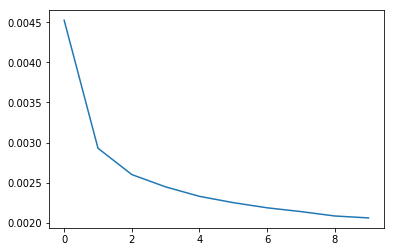

In [10]:
plt.plot(history.history['loss'])

Example

In [11]:
example_data = next(iter(train_dataset))

In [12]:
res = encoder_conv.predict(example_data)

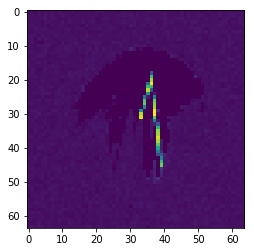

In [13]:
imshow(autoencoder_conv.predict(example_data)[0,:,:,0])

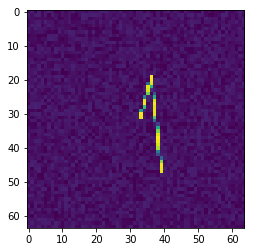

In [14]:
imshow(example_data[0][0,:,:,1])

### Visualization of ConvNet Filters

### Visualization of dense layers

### t-SNE 

### 3D t-SNE animation

## Control model

In [15]:
model = control_model()

In [16]:
optimizer = tf.keras.optimizers.Adam(1e-3)

model.compile(optimizer = 'adam', 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])

In [17]:
train_control_dataset = prepare_dataset(train_command, 
                                        train_posture_before,
                                       train_posture_after, 
                                       train_position_after, 
                                       train_position_before)

In [18]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

history = model.fit(train_control_dataset, 
                    epochs = 10)

Epoch 1/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0108 - accuracy: 0.9976 - kullback_leibler_divergence: 0.5207
Epoch 2/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0077 - accuracy: 1.0000 - kullback_leibler_divergence: 0.3778
Epoch 3/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0077 - accuracy: 1.0000 - kullback_leibler_divergence: 0.3768
Epoch 4/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0077 - accuracy: 1.0000 - kullback_leibler_divergence: 0.3763
Epoch 5/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0077 - accuracy: 1.0000 - kullback_leibler_divergence: 0.3766
Epoch 6/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0077 - accuracy: 1.0000 - kullback_leibler_divergence: 0.3764
Epoch 7/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0077 - accuracy: 1.0000 - kullback_leibler_divergence: 0.3764
Epoch 8/10
500/500 [==============

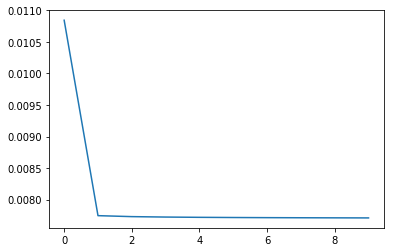

In [19]:
plt.plot(history.history['loss'])

### Control model 

In [20]:
def test_visuomotor_control(control_model, visual_direction):
    # liste des postures successives
    postures = []
    # choisir une posture initiale
    #posture = (np.random.random((1,3)))
    posture = np.array([[0.3,0.3,0.2]])
    postures.append(posture)

    for i in range(200):
        tmp = posture

        inputs = np.concatenate([visual_direction, tmp], axis = 0)
      
        inputs = np.expand_dims(inputs, 0)

        command = control_model.predict(inputs)

        posture = posture + command[0]/10   #otherwise its too strong

        posture = valid_posture(posture)
        postures.append(posture)

    return postures
 
def valid_posture(posture):
    valid_posture = posture
    
    for i in range(len(posture)):
        if posture[0][i] > 2*pi/3:
            valid_posture[0][i] = 2*pi/3
        if posture[0][i] < -2*pi/3:
            valid_posture[0][i] = -2*pi/3
    return valid_posture
            

In [21]:
postures = test_visuomotor_control(model, [[0,0,0]] )


In [22]:
def plot_arm_from_posture(posture):
    """function ploting and saving in /images 3d arm plot
    from arg joint state

    Args :
        phi1, phi2, theta1 : joint angles (3 dof arm )

    Returns :
        ax : a matplotlib figure object
    """
    phi1 = posture[0][0]
    phi2 = posture[0][1]
    theta1 = posture[0][2]
    
    fig = figure(facecolor=(0.0, 0.0, 0.0))
    ax = fig.gca(projection='3d')
    x = [0, 0, L1 * cos(phi1) * cos(theta1), L2 *
         cos(phi1 + phi2) * cos(theta1)]
    y = [0, 0, L1 * cos(phi1) * sin(theta1), L2 *
         cos(phi1 + phi2) * sin(theta1)]  # ELBOW + HAND
    z = [0, 0, L1 * sin(phi1), L2 * sin(phi1 + phi2)]  # ELBOW + HAND
    # ax.plot(x[0:1], y[0:1], z[0:1], label='shoulder', lw=2, color= 'k')
    # ax.plot(x[2:3], y[2:3], z[2:3], label='elbow', lw=2, color= 'c')
    # Hide grid lines
    ax.grid(False)
    # ax.set_autoscale_on(True)
    ax.set_facecolor((0.0, 0.0, 0.0))

    ax.set_xlim(left=-0.2, right=0.2)
    ax.set_ylim(bottom=-0.2, top=0.2)
    ax.set_zlim(bottom=-0.2, top=0.2)
    ax.axis('off')
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.plot(x, y, z, label='shoulder', lw=5, color='white')
    #filename = 'images/%s.png' % time
    #savefig(filename, facecolor=fig.get_facecolor(), edgecolor='none')
    
def plot_elbow_from_posture(posture):
    """function ploting and saving in /images 3d arm plot
    from arg joint state

    Args :
        phi1, phi2, theta1 : joint angles (3 dof arm )

    Returns :
        ax : a matplotlib figure object
    """
    phi1 = posture[0][0]
    phi2 = posture[0][1]
    theta1 = posture[0][2]
    
    fig = figure(facecolor=(0.0, 0.0, 0.0))
    ax = fig.gca(projection='3d')
    x = [0, 0, L1 * cos(phi1) * cos(theta1)]
    y = [0, 0, L1 * cos(phi1) * sin(theta1)]  # ELBOW + HAND
    z = [0, 0, L1 * sin(phi1)]  # ELBOW + HAND
    # ax.plot(x[0:1], y[0:1], z[0:1], label='shoulder', lw=2, color= 'k')
    # ax.plot(x[2:3], y[2:3], z[2:3], label='elbow', lw=2, color= 'c')
    # Hide grid lines
    ax.grid(False)
    # ax.set_autoscale_on(True)
    ax.set_facecolor((0.0, 0.0, 0.0))

    ax.set_xlim(left=-0.2, right=0.2)
    ax.set_ylim(bottom=-0.2, top=0.2)
    ax.set_zlim(bottom=-0.2, top=0.2)
    ax.axis('off')
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.plot(x, y, z, label='shoulder', lw=5, color='white')
    #filename = 'images/%s.png' % time
    #savefig(filename, facecolor=fig.get_facecolor(), edgecolor='none')
    


In [23]:
def control_robot_1(angles):
    """function calculating end effector postion from joint angles

    Args :
        phi1, phi2, theta1, theta2 : joint angles (4 dof arm )

    Returns:
        x,y,z : end effector position
        vx,vy,vz : speed i guess...
    """
    phi1, phi2, theta1 = angles
    theta2 = 0
    x = L1 * cos(phi1) * cos(theta1) + L2 * cos(phi1 + phi2) * \
        cos(theta1 + theta2)  # ELBOW + HAND
    y = L1 * cos(phi1) * sin(theta1) + L2 * cos(phi1 + phi2) * \
        sin(theta1 + theta2)  # ELBOW + HAND
    z = L1 * sin(phi1) + L2 * sin(phi1 + phi2)  # ELBOW + HAND
    vx = L2 * cos(phi1 + phi2) * cos(theta1 + theta2)
    vy = L2 * cos(phi1 + phi2) * sin(theta1 + theta2)
    vz = L2 * sin(phi1 + phi2)
    return [x, y, z]

def control_robot_elbow(angles):
    phi1, phi2, theta1 = angles
    x = L1 * cos(phi1) * cos(theta1)
    y = L1 * cos(phi1) * sin(theta1)
    z = L1 * sin(phi1)
    return np.array([x,y,z])

In [24]:
def compute_trajectory(postures):
    tmp = []
    for i in range(len(postures)):
        tmp.append(control_robot_1(postures[i][0]))
    return tmp
t = compute_trajectory(postures)
tprime = np.array(t)
#print tprime[:,2]

def compute_elbow_trajectory(postures):
    tmp = []
    for i in range(len(postures)):
        tmp.append(control_robot_elbow(postures[i][0]))
    return np.array(tmp)
t = compute_elbow_trajectory(postures)
print t[:,2]  

[0.08865606 0.08893506 0.08923591 0.08955854 0.08990292 0.09026897
 0.09065663 0.09106585 0.09149655 0.09194867 0.09242215 0.09291692
 0.09343289 0.09397001 0.09452819 0.09510735 0.09570743 0.09632833
 0.09696997 0.09763228 0.09831515 0.09901851 0.09974226 0.1004863
 0.10125054 0.10203488 0.10283923 0.10366346 0.10450749 0.10537121
 0.10625449 0.10715723 0.1080793  0.1090206  0.10998099 0.11096036
 0.11195857 0.1129755  0.114011   0.11506495 0.11613719 0.11722759
 0.118336   0.11946227 0.12060624 0.12176776 0.12294666 0.12414278
 0.12535595 0.12658599 0.12783274 0.12909601 0.13037561 0.13167136
 0.13298307 0.13431053 0.13565354 0.1370119  0.1383854  0.13977383
 0.14117696 0.14259457 0.14402643 0.14547232 0.14693198 0.14840517
 0.14989165 0.15139117 0.15290347 0.15442827 0.15596532 0.15751433
 0.15907504 0.16064714 0.16223036 0.1638244  0.16542895 0.1670437
 0.16866835 0.17030257 0.17194604 0.17359842 0.17525939 0.1769286
 0.17860569 0.18029031 0.1819821  0.1836807  0.18538573 0.1870968

<IPython.core.display.Javascript object>


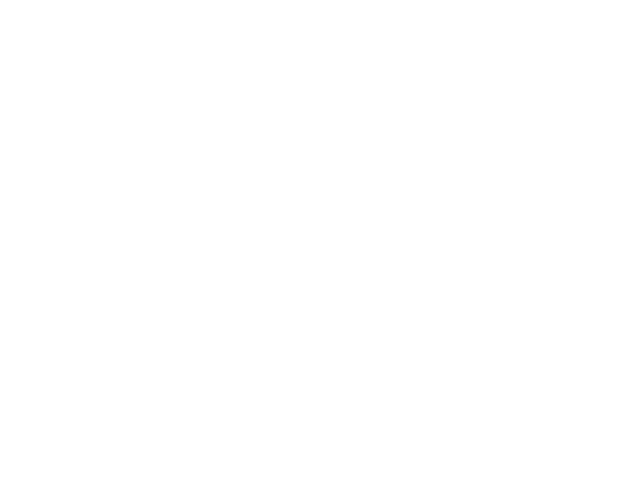

In [25]:
%matplotlib notebook

fig = plt.figure()

ax = plt.axes(projection='3d')
ax.set_xlim(left=-1, right=1)
ax.set_ylim(bottom=-1, top=1)
ax.set_zlim(bottom=-1, top=1)
ax.plot(t[:200,0], t[:200,1], t[:200,2])

In [26]:
%matplotlib notebook

fig = plt.figure()

ax = plt.axes(projection='3d')
ax.set_xlim(left=-1, right=1)
ax.set_ylim(bottom=-1, top=1)
ax.set_zlim(bottom=-1, top=1)
ax.plot(tprime[:200,0], tprime[:200,1], tprime[:200,2])

<IPython.core.display.Javascript object>

In [36]:
def go_to_position(control_model, target_position):
    postures = []
    current_posture = valid_posture(np.random.random((1,3)))

    visual_direction = compute_vd_from_position(target_position, current_posture)
    print 'visual_direction ', visual_direction
    postures.append(current_posture)
    j = 0
    while (distance_end_effector_to_target(visual_direction[0])) and (j < 100):
        
        inputs = np.expand_dims(np.concatenate([visual_direction, current_posture], axis=0), 0)
        
        new_command = control_model.predict(inputs)
       
        current_posture = current_posture + new_command[0]/10
        current_posture = valid_posture(current_posture)
        
        visual_direction = compute_vd_from_position(target_position, current_posture)
        postures.append(current_posture)
        j += 1
        
def compute_vd_from_position(target_position, current_posture):

    current_position = control_robot_1(current_posture[0])
    current_position  = np.expand_dims(current_position, 0)
    return np.subtract(target_position, current_position)

def distance_end_effector_to_target(visual_direction):
    dx, dy, dz = visual_direction
    
    dist = np.sqrt(dx*dx+dy*dy+dz*dz)
    
    return (dist > 0.2)
    

In [37]:
go_to_position(model, [[0.,0.,1]])

visual_direction  [[-0.35530606 -0.01575536  0.51689521]]


In [38]:
def compute_latent_control_filters(model, iterator):
    t = []
    for i in tqdm.tqdm(range(5000)):
        tmp = iterator.get_next()
        tmp = tf.expand_dims(tmp, 0)
        
        t.append(model.predict(tmp))
    
    return t

In [39]:
visu_control_dataset = (
    tf.data.Dataset.from_tensor_slices((tmp3))
    .repeat(10)
    .shuffle(NB_DATA)
)

NameError: name 'tmp3' is not defined

In [ ]:
res = compute_latent_control_filters(model, visu_control_dataset.__iter__())

In [ ]:
tmpp = []
for i in tqdm.tqdm(range(5000)):
    tmpp.append(res[i][0][0])
    
    

In [ ]:
tsne = TSNE(n_components=2, random_state=0, perplexity=50, early_exaggeration=4)
tsne_res = tsne.fit_transform(tmpp)

In [ ]:
plt.figure(figsize=(10, 10))
nb_classes = 8
for i in tqdm.tqdm(range(5000)):
    label_id = color_position[i] 
    plt.scatter(tsne_res[i,0], 
               tsne_res[i,1],
            color= plt.cm.Set1(label_id / float(nb_classes)))
plt.show()

### 3d visualization of neural activity

In [ ]:
%matplotlib notebook
def select_random_posture():
    posture = zeros(4)
    posture[0] = randrange(1,0,2*pi/3)
    posture[1] = randrange(1,0,2*pi/3)
    posture[2] = randrange(1,0,2*pi/3)
    return posture

def select_lin_posture(n):
    position = zeros((10*n*n, 4))
    phi1 = linspace(0,2*pi/3,n)
    phi2 = linspace(0,2*pi/3,n)
    theta1 = linspace(0,2*pi/3,n)
    xx, yy, zz = meshgrid(phi1, phi2, theta1)
    position[:,0] = xx.flatten()
    position[:,1] = yy.flatten()
    position[:,2] = zz.flatten()
    
    return position 

def select_lin_command(n):
    commands = zeros((10*n*n, 4))
    c0 = linspace(-1,1,n)*0.2
    c1 = linspace(-1,1,n)*0.2
    c2 = linspace(-1,1,n)*0.2
    cc0, cc1, cc2 = meshgrid(c0,c1,c2)
    commands[:,0] = cc0.flatten()
    commands[:,1] = cc1.flatten()
    commands[:,2] = cc2.flatten()
    
    return commands
    
def select_command():
    command = zeros(4)
    command[0] = randrange(1,-1, 1) * 0.25
    command[1] = randrange(1,-1, 1) * 0.25
    command[2] = random.choice(
        [-1, 1]) * np.sqrt(0.375 - (command[0] * command[0] + command[1] * command[1]))
    return command

def create_image_visu(posture, i):
    phi1, phi2, theta1 = posture[0], posture[1], posture[2]
    name = "visualization/%s" %i
    plot_arm(phi1, phi2, theta1, name)
    
def compute_random_activity_for_position(model, i):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    for k in (range(300)):
        posture_before = select_random_posture()
        position_before = control_robot(posture_before)
        name_before = "fig_before_%s" %k
        create_image_visu(posture_before, name_before)
        
        tmp0 = "images/visualization/" + name_before + ".png"
        
        tens_before = load_and_preprocess_image(tmp0)
        noised_tens_before = noised_image(tens_before)
        
        for j in range(10):
            res = []
            command = select_command()
            posture_after = posture_before + command
            position_after = control_robot(posture_after)
            name_after = "fig_after_%s_%s" %(k, j)
            create_image_visu(posture_after, name_after)
            
            tmp1 = "images/visualization/" + name_after + ".png"

            tens_after = load_and_preprocess_image(tmp1)
            noised_tens_after = noised_image(tens_after)
            
            t = tf.concat([noised_tens_before, noised_tens_after], -1)
            r = tf.reshape(t, [1,IMG_SIZE, IMG_SIZE, 2])
            
            
            output = model.predict(r)
            res.append(output[0][0][i])
        
        moy = mean(res)
       
        ax.scatter3D(position_before[0], position_before[1], position_before[2], color= plt.cm.Greens((moy) *2))
        
    plt.show()

def compute_activity_for_position(model, i):
    """ compute averaged-command initial position-specific neural activity
    
    Args : 
        model : a keras model object
        i : neuron index
    
    Returns : 
        null
    """
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    postures = select_lin_posture(10)
    command = select_command()
    for k in (range(300)):
        
        posture_before = postures[k]
        position_before = control_robot(posture_before)
        name_before = "fig_before_%s" %k
        create_image_visu(posture_before, name_before)
        
        tmp0 = "images/visualization/" + name_before + ".png"
        
        tens_before = load_and_preprocess_image(tmp0)
        noised_tens_before = noised_image(tens_before)
        
        for j in range(10):
            res = []
            
            posture_after = posture_before + command
            position_after = control_robot(posture_after)
            name_after = "fig_after_%s_%s" %(k, j)
            create_image_visu(posture_after, name_after)
            
            tmp1 = "images/visualization/" + name_after + ".png"

            tens_after = load_and_preprocess_image(tmp1)
            noised_tens_after = noised_image(tens_after)
            
            t = tf.concat([noised_tens_before, noised_tens_after], -1)
            r = tf.reshape(t, [1,IMG_SIZE, IMG_SIZE, 2])
            
            
            output = model.predict(r)
            res.append(output[0][0][i])
        
        moy = mean(res)
       
        ax.scatter3D(position_before[0], position_before[1], position_before[2], color= plt.cm.seismic((moy)))
        
    plt.show()
   

In [ ]:
compute_activity_for_position(encoder_conv, 50)

In [ ]:
%matplotlib inline
def compute_loss_vd(model, pos_init, joint_command, filter_index):
    img = generate_input_from_vd(pos_init,  joint_command)
    output = model.predict(img)
    loss = output[0][0][filter_index]
    
    return loss

#@tf.function
def generate_img_from_pos(phi1, phi2, theta1):
    
    fig = figure(facecolor=(0.0, 0.0, 0.0))
    ax = fig.gca(projection='3d')
    phi1 = tf.cast(phi1, tf.float32)
    phi2 = tf.cast(phi2, tf.float32)
    theta1 = tf.cast(theta1, tf.float32)

    x = [0, 0, L1 * tf.math.cos(phi1) * tf.math.cos(theta1), L2 *
         tf.math.cos(phi1 + phi2) * tf.math.cos(theta1)]
    y = [0, 0, L1 * tf.math.cos(phi1) * tf.math.sin(theta1), L2 *
         tf.math.cos(phi1 + phi2) * tf.math.sin(theta1)]  # ELBOW + HAND
    z = [0, 0, L1 * tf.math.sin(phi1), L2 * tf.math.sin(phi1 + phi2)]  # ELBOW + HAND
   
    ax.grid(False)
    ax.set_facecolor((0.0, 0.0, 0.0))
    ax.set_xlim(left=-0.2, right=0.2)
    ax.set_ylim(bottom=-0.2, top=0.2)
    ax.set_zlim(bottom=-0.2, top=0.2)
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.plot(x, y, z, label='shoulder', lw=5, color='white')
    
    fig.canvas.draw()
    
    x = np.array(fig.canvas.renderer.buffer_rgba())
    x = np.reshape(x, (288,432,4))
    
    tmp = tf.image.resize(x, [IMG_SIZE, IMG_SIZE])
    #tmp = tf.reshape(tmp, [1,64,64,4])
    
    plt.close()
    
    return tmp


def generate_input_from_vd(pos_before, joint_command):

    pos_before = tf.reshape(pos_before, [1,4])
    img_before = generate_img_from_pos(pos_before[0][0],
                                      pos_before[0][1],
                                      pos_before[0][2])
    
    pos_after = np.add(pos_before , joint_command)
    img_after = generate_img_from_pos(pos_after[0][0],
                                      pos_after[0][1],
                                      pos_after[0][2])
    
    t =  tf.concat([img_before[:,:,:1], img_after[:,:,:1]], -1)
    t = tf.reshape(t, [1, IMG_SIZE, IMG_SIZE, 2])
    
    return t

def generate_max_vd(model, filter_index, nb_pass):
    
    list_pos_before = []
    list_loss = []
    list_joint_command = []

    for i in tqdm.tqdm(range(100)):
        
        joint_command = tf.convert_to_tensor(
            np.random.random((1,4)), dtype = 'float32')
        pos_before = tf.convert_to_tensor(
            np.random.random((1,4)), dtype='float32')

        tmp_loss = 0
        tmp_joint_command = joint_command
        
        list_pos_before.append(pos_before)
        j = 0
        #for j in (range(nb_pass)):
        while (tmp_loss < 10000) and (j < 100):
            new_joint_command = zeros((1,4))
            #new_joint_command[0][0] = random.choice([-1,-1])*randrange(1, 0, 0.2)
            #new_joint_command[0][1] = random.choice([-1,-1])*randrange(1, 0, 0.2)
            #new_joint_command[0][2] = random.choice([-1,-1])*randrange(1, 0, 0.2)
        
            new_joint_command[0][0] = random.choice([-1,1])*0.25
            new_joint_command[0][1] = random.choice([-1,1])*0.25
            new_joint_command[0][2] = random.choice([-1,1])*np.sqrt(
                0.375 -  (new_joint_command[0][0] * new_joint_command[0][0] + new_joint_command[0][1] * new_joint_command[0][1]))
            
            new_loss = compute_loss_vd(model, 
                                       pos_before, 
                                       new_joint_command, 
                                       filter_index)
            
            if (new_loss > tmp_loss) :
                tmp_loss = new_loss
                tmp_joint_command = new_joint_command
            #else : 
            #    pass
            j += 1
        list_loss.append(tmp_loss)
        list_joint_command.append(tmp_joint_command)
    
    return list_loss, list_joint_command, list_pos_before
            

In [ ]:
%matplotlib inline
model = encoder_conv
list_loss, list_joint_command, list_pos_before = generate_max_vd(model, 35, 50)

In [ ]:
%matplotlib notebook
%matplotlib notebook  
def plot_max_vd(list_pos_before, list_joint_command):
    fig = figure(facecolor=(0.0, 0.0, 0.0))
    ax = fig.gca(projection='3d')
    for i in (range(100)):
        if (list_loss[i] == 0) : #or (list_loss[i] < mean(list_loss)):
            pass
        else : 
            position_before = control_robot(list_pos_before[i][0])
            posture_after = np.add(list_pos_before[i][0], list_joint_command[i][0])
            position_after = control_robot(posture_after)
            plt.quiver(position_before[0], 
                       position_before[1], 
                       position_before[2], 
                       position_after[0], 
                       position_after[1], 
                       position_after[2], 
                       length = 0.1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    plt.title('Receptive field of visuomotor neuron')
    plt.show()
%matplotlib notebook   
%matplotlib notebook

In [ ]:
plot_max_vd(list_pos_before, list_joint_command)

In [ ]:
random.choice([-1,-1])*randrange(1, 0, 0.2)

In [ ]:
def multiple_contribution(model, nb_pass):
    pos_before1 = tf.convert_to_tensor(
        np.random.random((1,4)), dtype='float32')
    pos_before2 = tf.convert_to_tensor(
        np.random.random((1,4)), dtype='float32')
    
    list_joint_cmd1 = []
    list_joint_cmd2 = []
    pos = []
    pos.append(pos_before1)
    pos.append(pos_before2)
    
    for i in tqdm.tqdm(range(32)):
        tmp_loss1 = 0
        tmp_loss2 = 0
        
        tmp_joint_command1 = zeros((1,4))
        tmp_joint_command2 = zeros((1,4))
        
        for j in range(nb_pass):
            new_joint_command1 = zeros((1,4))
            new_joint_command1[0][0] = random.choice([-1,1])*0.25
            new_joint_command1[0][1] = random.choice([-1,1])*0.25
            new_joint_command1[0][2] = random.choice([-1,1])*np.sqrt(
                0.375 -  (new_joint_command1[0][0] * new_joint_command1[0][0] + new_joint_command1[0][1] * new_joint_command1[0][1]))
          
        
            new_joint_command2 = zeros((1,4))
            new_joint_command2[0][0] = random.choice([-1,1])*0.25
            new_joint_command2[0][1] = random.choice([-1,1])*0.25
            new_joint_command2[0][2] = random.choice([-1,1])*np.sqrt(
                0.375 -  (new_joint_command2[0][0] * new_joint_command2[0][0] + new_joint_command2[0][1] * new_joint_command2[0][1]))
            
            loss1 = compute_loss_vd(model, pos_before1, new_joint_command1, i )
            loss2 = compute_loss_vd(model, pos_before2, new_joint_command2, i )
            
            if (loss1 > tmp_loss1):
                tmp_loss1 = loss1
                tmp_joint_command1 = new_joint_command1
            
            if (loss2 > tmp_loss2):
                tmp_loss2 = loss2
                tmp_joint_command2 = new_joint_command2
                
        list_joint_cmd1.append(tmp_joint_command1)
        list_joint_cmd2.append(tmp_joint_command2)
        
    return pos, list_joint_cmd1, list_joint_cmd2
            

In [ ]:
model_encoder = encoder_conv
pos, list_joint_cmd1, list_joint_cmd2 = multiple_contribution(model, 10)

In [ ]:
%matplotlib notebook
def plot_multiple_contrib(pos, list_joint_cmd1, indice):
    fig = figure(facecolor=(0.0,0.0,0.0))
    ax = fig.gca(projection="3d")
    
    for i in tqdm.tqdm(range(32)):
        position_before = pos[indice][0]
        posture_after = np.add(position_before, list_joint_cmd1[i][0])
        position_after = control_robot(posture_after)
        plt.quiver(position_before[0],
                  position_before[1], 
                  position_before[2], 
                  position_after[0], 
                  position_after[1], 
                  position_after[2], 
                  length = 0.1, 
                  color = plt.cm.Set1(i/32.0))
    plt.show()

In [ ]:
plot_multiple_contrib(pos, list_joint_cmd1, 0)

In [ ]:
plot_multiple_contrib(pos,list_joint_cmd2, 1)